Minimum image and text conditional diffusion DDPM training / generation code for personal understaning.  

- data : sample synthesized image with shape (128, 128, 3) along with conditioning circle image and describing text. (borrowed from diffusers)    
- model : simple conditional Unet with time embedding  
- text encoder : pretrained light weight encoder `sentence-transformers/all-MiniLM-L6-v2` (freezed)  
- no latent encoder such as VAE (i.e., non latent diffusion)  
- timestep conditionong : applys shift and scale modulate by timesteps to iamge and conditioning image stacked image  
- conditioning image conditioning : simply stack input image and conditioning image along channels  
- text conditioning : fuse image latents with text embedding using cross attention at each Unet layers  


In [1]:
!pip install -q datasets einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from typing import Tuple, Any, List, Dict
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image

In [3]:
# Data Config
IMG_SHAPE = (3, 128, 128)

TEXT_PADDING_MAX_LENGTH = 100
TEXT_EMB_DIM = 384

# Training Config
EPOCHS = 15
TRAIN_BATCH_SIZE = 32
LR = 3e-4
WEIGHT_DECAY = 1e-2

# Diffusion Config
STEPS = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

## 1. Load Pretrained Text Encoder

In [5]:
# text_encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').eval()
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
text_encoder = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device).eval()
text_encoder._requires_grad = False

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

## 2. Data Pereparation

In [6]:
hf_dataset = load_dataset('fusing/fill50k', trust_remote_code=True)['train']

fill50k.py:   0%|          | 0.00/2.88k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/7.00M [00:00<?, ?B/s]

images.zip:   0%|          | 0.00/109M [00:00<?, ?B/s]

conditioning_images.zip:   0%|          | 0.00/123M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
hf_dataset

Dataset({
    features: ['image', 'conditioning_image', 'text'],
    num_rows: 50000
})

In [8]:
hf_dataset.to_pandas().head()

image  \
0  {'bytes': None, 'path': '/root/.cache/huggingf...   
1  {'bytes': None, 'path': '/root/.cache/huggingf...   
2  {'bytes': None, 'path': '/root/.cache/huggingf...   
3  {'bytes': None, 'path': '/root/.cache/huggingf...   
4  {'bytes': None, 'path': '/root/.cache/huggingf...   

                                  conditioning_image  \
0  {'bytes': None, 'path': '/root/.cache/huggingf...   
1  {'bytes': None, 'path': '/root/.cache/huggingf...   
2  {'bytes': None, 'path': '/root/.cache/huggingf...   
3  {'bytes': None, 'path': '/root/.cache/huggingf...   
4  {'bytes': None, 'path': '/root/.cache/huggingf...   

                                                text  
0    pale golden rod circle with old lace background  
1           light coral circle with white background  
2             aqua circle with light pink background  
3  cornflower blue circle with light golden rod y...  
4       light slate gray circle with blue background

In [9]:
hf_dataset[0]['image'].size, hf_dataset[0]['conditioning_image'].size, hf_dataset[0]['text']

((512, 512), (512, 512), 'pale golden rod circle with old lace background')

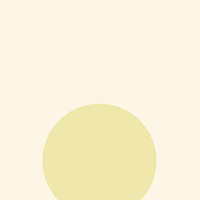

In [10]:
hf_dataset[0]['image'].resize((200, 200))

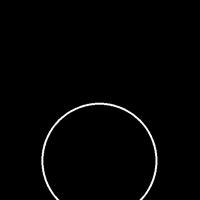

In [11]:
hf_dataset[0]['conditioning_image'].resize((200, 200))

In [12]:
image_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(IMG_SHAPE[1:], interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.CenterCrop(IMG_SHAPE[1:]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5], [0.5]),
    ]
)

conditioning_image_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(IMG_SHAPE[1:], interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.CenterCrop(IMG_SHAPE[1:]),
        torchvision.transforms.ToTensor(),
    ]
)

In [13]:
@torch.inference_mode()
def encode_text(texts):
    inputs = tokenizer(texts, padding='max_length', max_length=TEXT_PADDING_MAX_LENGTH, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    text_encoder_output = text_encoder(**inputs)
    text_emb = text_encoder_output['last_hidden_state']
    return inputs['attention_mask'].bool(), text_emb

def preprocess_data(examples):
    images = [image.convert("RGB") for image in examples['image']]
    images = [image_transforms(image) for image in images]

    conditioning_images = [image.convert("RGB") for image in examples['conditioning_image']]
    conditioning_images = [conditioning_image_transforms(image) for image in conditioning_images]

    examples["pixel_values"] = images
    examples["conditioning_pixel_values"] = conditioning_images
    text_attn_mask, text_emb = encode_text(examples['text'])
    examples["text_emb"] = text_emb
    examples["text_attn_mask"] = text_attn_mask

    return examples

In [14]:
%%time
hf_dataset = hf_dataset.with_transform(preprocess_data)

CPU times: user 745 ms, sys: 234 ms, total: 979 ms
Wall time: 1.28 s


In [15]:
hf_dataset[0].keys()

dict_keys(['image', 'conditioning_image', 'text', 'pixel_values', 'conditioning_pixel_values', 'text_emb', 'text_attn_mask'])

In [16]:
hf_dataset[0]['pixel_values'].shape, hf_dataset[0]['conditioning_pixel_values'].shape, hf_dataset[0]['text_emb'].shape, hf_dataset[0]['text_attn_mask'].shape

(torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([100, 384]),
 torch.Size([100]))

In [17]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    text_emb = torch.stack([example["text_emb"] for example in examples])
    text_attn_mask = torch.stack([example["text_attn_mask"] for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        "text_emb": text_emb,
        'text_attn_mask': text_attn_mask,
    }

In [18]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)

In [17]:
_batch = next(iter(train_dataloader))

In [18]:
{k: v.shape for k, v in _batch.items()}

{'pixel_values': torch.Size([64, 3, 128, 128]),
 'conditioning_pixel_values': torch.Size([64, 3, 128, 128]),
 'text_emb': torch.Size([64, 100, 384]),
 'text_attn_mask': torch.Size([64, 100])}

## 3. Model

In [19]:
# Time Embedder (borrowed from micro diffusion)

class TimestepEmbedder(nn.Module):
    """Embeds scalar timesteps into vector representations.

    Args:
        hidden_size (int): Size of hidden dimension
        act_layer (Any): Activation layer constructor
        frequency_embedding_size (int, 512): Size of frequency embedding
    """
    def __init__(
        self,
        hidden_size: int,
        act_layer: Any = nn.SiLU,
        frequency_embedding_size: int = 512
    ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            act_layer(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t: torch.Tensor, dim: int, max_period: int = 10000) -> torch.Tensor:
        """Create sinusoidal timestep embeddings."""
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(
                start=0,
                end=half,
                dtype=torch.float32,
                device=t.device
            ) / half
        )
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size).to(self.dtype)
        return self.mlp(t_freq)

    @property
    def dtype(self) -> torch.dtype:
        return next(self.parameters()).dtype

In [20]:
TimestepEmbedder(hidden_size=28*28).eval()(torch.arange(0, 1000)).detach().shape

torch.Size([1000, 784])

In [48]:
def modulate(x: torch.Tensor, shift: torch.Tensor, scale: torch.Tensor) -> torch.Tensor:
    """Applies modulation to input tensor using shift and scale factors."""
    return x * (1 + scale) + shift

def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe

In [49]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels = 6, out_channels = 3, ch_scale = 1, c_emb_dim = TEXT_EMB_DIM):
        super(ConditionalUNet, self).__init__()

        # エンコーダ部分
        self.enc1 = self.conv_block(in_channels, 64 // ch_scale)
        self.enc1_c_in_proj = nn.Linear(c_emb_dim, self.enc1[0].out_channels)
        self.enc2 = self.conv_block(64 // ch_scale, 128 // ch_scale)
        self.enc2_c_in_proj = nn.Linear(c_emb_dim, self.enc2[0].out_channels)
        self.enc3 = self.conv_block(128 // ch_scale, 256 // ch_scale)
        self.enc3_c_in_proj = nn.Linear(c_emb_dim, self.enc3[0].out_channels)
        self.enc4 = self.conv_block(256 // ch_scale, 512 // ch_scale)
        self.enc4_c_in_proj = nn.Linear(c_emb_dim, self.enc4[0].out_channels)

        # ボトム部分
        self.center = self.conv_block(512 // ch_scale, 1024 // ch_scale)
        self.center_c_in_proj = nn.Linear(c_emb_dim, self.center[0].out_channels)

        # デコーダ部分
        self.upconv4 = self.upconv_block(1024 // ch_scale, 512 // ch_scale)
        self.upconv4_c_in_proj = nn.Linear(c_emb_dim, self.upconv4[0].out_channels)
        self.upconv3 = self.upconv_block(512 // ch_scale, 256 // ch_scale)
        self.upconv3_c_in_proj = nn.Linear(c_emb_dim, self.upconv3[0].out_channels)
        self.upconv2 = self.upconv_block(256 // ch_scale, 128 // ch_scale)
        self.upconv2_c_in_proj = nn.Linear(c_emb_dim, self.upconv2[0].out_channels)
        self.upconv1 = self.upconv_block(128 // ch_scale, 64 // ch_scale)
        self.upconv1_c_in_proj = nn.Linear(c_emb_dim, self.upconv1[0].out_channels)

        # 出力層
        self.final_conv = nn.Conv2d(64 // ch_scale, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def upconv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x, c, c_mask = None):
        """
        x: image tensor of shape (bs, ch, h, w)
        c: conditional embeddings of shape (bs, seq_len_c, emb_dim)
        c_mask: attention mask for c of shape (bs, seq_len_c)
        """
        # エンコーダ
        enc1 = self.enc1(x)
        # enc1_c_fused = self._fuse_x_and_cond(enc1, self.enc1_c_in_proj(c), c_mask)
        enc1_c_fused = enc1
        enc2 = self.enc2(F.max_pool2d(enc1_c_fused, 2))
        enc2_c_fused = self._fuse_x_and_cond(enc2, self.enc2_c_in_proj(c), c_mask)
        enc3 = self.enc3(F.max_pool2d(enc2_c_fused, 2))
        enc3_c_fused = self._fuse_x_and_cond(enc3, self.enc3_c_in_proj(c), c_mask)
        enc4 = self.enc4(F.max_pool2d(enc3_c_fused, 2))
        enc4_c_fused = self._fuse_x_and_cond(enc4, self.enc4_c_in_proj(c), c_mask)

        # ボトム部分
        center = self.center(F.max_pool2d(enc4_c_fused, 2))
        center_c_fused = self._fuse_x_and_cond(center, self.center_c_in_proj(c), c_mask)

        # デコーダ
        up4 = self.upconv4(center_c_fused)
        up4_c_fused = self._fuse_x_and_cond(up4, self.upconv4_c_in_proj(c), c_mask)
        up3 = self.upconv3(up4_c_fused + enc4_c_fused)  # skip connection
        up3_c_fused = self._fuse_x_and_cond(up3, self.upconv3_c_in_proj(c), c_mask)
        up2 = self.upconv2(up3_c_fused + enc3_c_fused)  # skip connection
        up2_c_fused = self._fuse_x_and_cond(up2, self.upconv2_c_in_proj(c), c_mask)
        up1 = self.upconv1(up2_c_fused + enc2_c_fused)  # skip connection
        # up1_c_fused = self._fuse_x_and_cond(up1, self.upconv1_c_in_proj(c), c_mask)
        up1_c_fused = up1

        # 最終出力
        output = self.final_conv(up1_c_fused + enc1_c_fused)  # skip connection
        return output

    def _fuse_x_and_cond(self, x, c, c_mask):
        x_patched = self._patchfy(x)  # (bs, ch, h, w) => (bs, x_seq_len, ch)
        x_seqlen = x_patched.shape[1]
        mask = c_mask.unsqueeze(1).repeat((1, x_seqlen,1)) if c_mask is not None else None  # (bs, seq_len_c) => (bs, seq_len_xpacth, seq_len_c)
        x_c_fused = F.scaled_dot_product_attention(
            query=x_patched, key=c, value=c,
            attn_mask=mask,
            dropout_p=0.05,
            is_causal=False
        )
        x_c_fused = self._unpatchify(x_c_fused)  # (bs, x_seq_len, ch) => (bs, ch, h, w)
        assert x.shape == x_c_fused.shape
        return x + x_c_fused

    def _patchfy(self, x):
        """convert image (bs, ch, h, w) to sequential format (bs, h x w, ch)
        x: image tensor of shape (bs, ch, h, w)
        """
        bs, ch, h, w = x.shape
        return einops.rearrange(x, 'b c h w -> b (h w) c')

    def _unpatchify(self, x):
        """convert sequential image (bs, h x w, ch) to (bs, ch, h, w)
        x: image tensor of shape (bs, h x w, ch)
        """
        bs, hxw, ch = x.shape
        h = w = int(hxw**0.5)
        return einops.rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

In [50]:
class DenoiseModel(torch.nn.Module):
    def __init__(
        self,
        img_shape: Tuple[int, int, int] = IMG_SHAPE,  # (ch, h, w)
        cond_image_shape: Tuple[int, int, int] = IMG_SHAPE,
        time_emb_dim: int = 512,
    ):
        super().__init__()
        self._img_shape = img_shape
        self._cond_image_shape = cond_image_shape
        self._unet_denoiser = ConditionalUNet()
        self._timestep_embedder = TimestepEmbedder(hidden_size=time_emb_dim)
        self._adaLN_modulation = nn.Sequential(
            nn.GELU(approximate="tanh"),
            nn.Linear(time_emb_dim, 2 * np.prod(self._img_shape[1:]) * (self._img_shape[0] + self._cond_image_shape[0]), bias=True),
        )
        self._c_pos_emb = positionalencoding1d(TEXT_EMB_DIM, TEXT_PADDING_MAX_LENGTH)

    def forward(self, x: torch.Tensor, t: torch.Tensor, cond_image: torch.Tensor, c, c_mask = None):
        """Given noisy input image x_t and time t, predict the added noise (x_t - x_t-1).

        Args:
            x (torch.Tensor): input noisy image x_t with shape (bs, ch, h, w)
            t (torch.Tensor): time steps with shape (bs,)
            cond_image (torch.Tensor): conditioning image with shape (bs, ch, h, w)
            c (torch.Tensor): conditional embeddings with shape (bs, seq_len_c, emb_dim)
            c_mask (torch.Tensor): attention mask for c with shape (bs, seq_len_c)

        Returns:
            torch.Tensor: Predicted added noise image (x_t - x_t-1) with shape (bs, ch, h, w)
        """
        bs, ch, h , w = x.shape
        assert self._img_shape == (ch, h, w)
        x_cond_stacked = torch.cat([x, cond_image], dim=1)  # (bs, ch_x + ch_cond, h ,w)
        t_emb = self._timestep_embedder(t)  # (bs,) => (bs, time_emb_dim)
        shift, scale = self._adaLN_modulation(t_emb).chunk(2, dim=1)
        shift = shift.reshape(*x_cond_stacked.shape)  # (bs, ch x h x w) => (bs, ch, h, w)
        scale = scale.reshape(*x_cond_stacked.shape)  # (bs, ch x h x w) => (bs, ch, h, w)
        x_t_fused = modulate(x_cond_stacked, shift, scale)  # make x+cond_image conditioned on timesteps
        c = c + self._c_pos_emb.to(c.device)
        added_noise = x - self._unet_denoiser(x_t_fused, c=c, c_mask=c_mask)
        return added_noise

In [24]:
_denoise_model = DenoiseModel().to(device).eval()

In [25]:
with torch.inference_mode():
    _out = _denoise_model(
        torch.randn(1, 3, *IMG_SHAPE[-2:]).to(device),
        torch.tensor([0.0]).to(device),
        cond_image=torch.randn(1, 3, *IMG_SHAPE[-2:]).to(device),
        c=torch.randn(1, TEXT_PADDING_MAX_LENGTH, TEXT_EMB_DIM).to(device),
        c_mask=torch.ones(1, TEXT_PADDING_MAX_LENGTH).to(device),
    )
    print(_out.shape)

torch.Size([1, 3, 128, 128])


## 4. DDPM Scheduler Utils

In [26]:
def get_alpha_beta_sigma_scheduler(
    steps: int,
    # noise_beta = (0.5, 1.0),
    noise_beta = (0.0001, 0.02),
    device = device,
) -> Tuple[torch.Tensor, torch.Tensor]:
    b1, b2 = noise_beta
    beta_scheduler = [b1 + i*(b2-b1)/steps for i in range(steps)]
    alpha_scheduler = [1.0 - beta for beta in beta_scheduler]
    beta_scheduler = torch.tensor(beta_scheduler, device=device, dtype=torch.float32)
    alpha_scheduler = torch.tensor(alpha_scheduler, device=device, dtype=torch.float32)
    alpha_cumprod_scheduler = alpha_scheduler.cumprod(0)
    sigma_scheduler = (beta_scheduler * (1.0 - alpha_cumprod_scheduler.roll(1)) / (1.0 - alpha_cumprod_scheduler)).sqrt()
    sigma_scheduler[0] = 0.0
    return beta_scheduler.to(device), alpha_scheduler.to(device), alpha_cumprod_scheduler.to(device), sigma_scheduler.to(device)

In [27]:
beta_scheduler, alpha_scheduler, alpha_cumprod_scheduler, sigma_scheduler = get_alpha_beta_sigma_scheduler(steps=STEPS, noise_beta=(0.0001, 0.02))

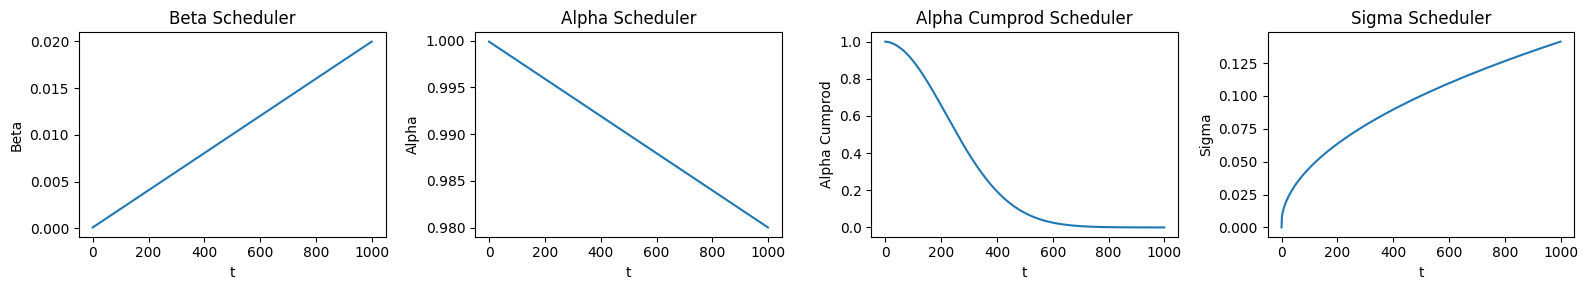

In [28]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(4*4, 3))

axes[0].plot(beta_scheduler.cpu().numpy())
axes[0].set_xlabel('t')
axes[0].set_ylabel('Beta')
axes[0].set_title('Beta Scheduler')

axes[1].plot(alpha_scheduler.cpu().numpy())
axes[1].set_xlabel('t')
axes[1].set_ylabel('Alpha')
axes[1].set_title('Alpha Scheduler')

axes[2].plot(alpha_cumprod_scheduler.cpu().numpy())
axes[2].set_xlabel('t')
axes[2].set_ylabel('Alpha Cumprod')
axes[2].set_title('Alpha Cumprod Scheduler')

axes[3].plot(sigma_scheduler.cpu().numpy())
axes[3].set_xlabel('t')
axes[3].set_ylabel('Sigma')
axes[3].set_title('Sigma Scheduler')

fig.tight_layout()

## 5. Denoise(generation) / Add Noise Utils

- Denoise (For Generation)

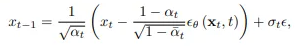

Following above equations, apply denoising process step by step to generate final image $x_0$ starting from pure noise $x_{t_{max}} \sim \mathcal{N}(0,\,1)$, where  
$\alpha_t=1-\beta_t$  
$\overline{\alpha}_{t} = \prod \alpha_t = \prod (1-\beta_t)$  
$ \sigma_{t}^2 = \frac{1.0 - \overline{\alpha}_{t-1}}{1.0 - \overline{\alpha}_{t}}\beta_t$  
$\epsilon_{\theta}(\boldsymbol{x}_{t}, t)$ : model output (predicted noise added to $x_t$)  
$\epsilon \sim \mathcal{N}(0,\,1)$


In [29]:
@torch.inference_mode()
def generate(
    denoise_model: nn.Module,
    texts: List[str],
    cond_images: List[Image.Image],
    img_shape: Tuple[int, int, int] = IMG_SHAPE,
    steps: int = STEPS,
    beta_scheduler: torch.Tensor = beta_scheduler,
    alpha_scheduler: torch.Tensor = alpha_scheduler,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
    sigma_scheduler: torch.Tensor = sigma_scheduler,
    debug: bool = False,
    device = device,
    return_only_final_image: bool = True,
) -> torch.Tensor:
    denoise_model.eval()
    # create initial pure noise x_tmax
    assert len(texts) == len(cond_images)
    text_attn_mask, text_emb = encode_text(texts)
    cond_images = torch.stack([conditioning_image_transforms(img) for img in cond_images], dim=0)
    bs = len(texts)
    x_t = init_noise = torch.randn(bs, *img_shape).to(device)
    x_t_list = [x_t] if not return_only_final_image else None

    for t in reversed(range(1, steps)):
        # predict noise to denoise from x_t
        pred_noise = denoise_model(
            x_t,
            torch.tensor([t]).repeat((bs,)).to(device),
            cond_image=cond_images.to(device),
            c=text_emb.to(device),
            c_mask=text_attn_mask.to(device),
        )
        if debug:
            print('pred', (pred_noise.min(), pred_noise.max()), (x_t.min(), x_t.max()))
        # apply denoise equation above
        x_prev_t = x_t - pred_noise * (1 - alpha_scheduler[t]) / ((1 - alpha_cumprod_scheduler[t]).sqrt())
        x_prev_t /= alpha_scheduler[t].sqrt()
        x_prev_t += sigma_scheduler[t] * torch.randn_like(x_prev_t)
        x_t = x_prev_t
        if debug:
            print(x_prev_t.max())
        if not return_only_final_image:
            x_t_list.append(x_t)

    if return_only_final_image:
        x_0 = x_t  # generated image x_0  (n_generate, ch, h, w)
    else:
        x_0 = torch.stack(x_t_list, dim=0)  # (steps, n_generate, ch, h, w)
    return x_0

In [30]:
gen_img = generate(_denoise_model, texts=[hf_dataset[0]['text']], cond_images=[hf_dataset[0]['conditioning_image']])
print(gen_img.shape)

torch.Size([1, 3, 128, 128])


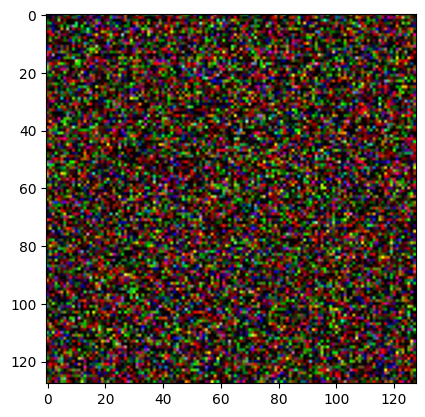

In [31]:
plt.imshow(gen_img[0].cpu().permute(1, 2, 0))

- Add Noise (For Training)

image.png

In [32]:
def add_noise(
    x_0: torch.Tensor,
    steps: int = STEPS,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Add noise corresponding to random time steps to ground-truth image x_0 to get x_t_rand

    Args:
        x (torch.Tensor): input ground-trueth image x_0 with shape (bs, ch, h, w)

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: noised added image x_t_rand, added noise, random timestepps correponsing to added noise
    """
    bs, ch, h, w = x_0.shape
    random_timesteps = torch.randint(0, steps, (bs,)).to(x_0.device)
    alpha_prod = alpha_cumprod_scheduler[random_timesteps].reshape((bs, 1, 1, 1))

    noise = torch.randn_like(x_0)
    x_noisy = x_0 * alpha_prod.sqrt() + noise * (1 - alpha_prod).sqrt()
    return x_noisy, noise, random_timesteps

In [52]:
_x_noisy, _noise, _random_timesteps = add_noise(next(iter(train_dataloader))['pixel_values'].to(device))
print(_x_noisy.shape, _noise.shape, _random_timesteps.shape)

torch.Size([64, 3, 128, 128]) torch.Size([64, 3, 128, 128]) torch.Size([64])


## 6. Run Training

In [33]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [51]:
model = DenoiseModel().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [52]:
loss_history = []

for epoch in range(EPOCHS):
    # Train phase
    model.train()
    epoch_loss = 0.0
    for batch in pb(train_dataloader):
        batch = batch_to_device(batch, device)
        optimizer.zero_grad()
        x = batch['pixel_values']
        cond_images = batch['conditioning_pixel_values']
        text_emb = batch['text_emb']
        text_attn_mask = batch['text_attn_mask']
        x_noisy, noise, random_timesteps = add_noise(x, steps=STEPS)  # (bs, ch, h, w), (bs, ch, h, w), (bs,)
        pred_noise = model(
            x=x_noisy,
            t=random_timesteps,
            cond_image=cond_images,
            c=text_emb,
            c_mask=text_attn_mask,
        )  # (bs, ch, h, w)
        loss = torch.nn.functional.mse_loss(pred_noise.cpu().float(), noise.cpu().float())
        if torch.isnan(loss):
            print('loss is nan')
            break
        loss.backward()
        optimizer.step()
        epoch_loss += loss.cpu().detach()
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]}')

    # Ealuluation Phase
    model.eval()
    random_selected_data = hf_dataset.shuffle().select(range(3))[:]
    print(random_selected_data['text'])
    display(random_selected_data['image'][0].resize((100, 100)))
    display(random_selected_data['image'][1].resize((100, 100)))
    display(random_selected_data['image'][2].resize((100, 100)))
    gen_img = generate(model, texts=random_selected_data['text'], cond_images=random_selected_data['conditioning_image'])
    gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())
    grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=3)
    plt.figure(figsize=(3*3, 3))
    plt.imshow(grid_image.permute(1, 2, 0))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

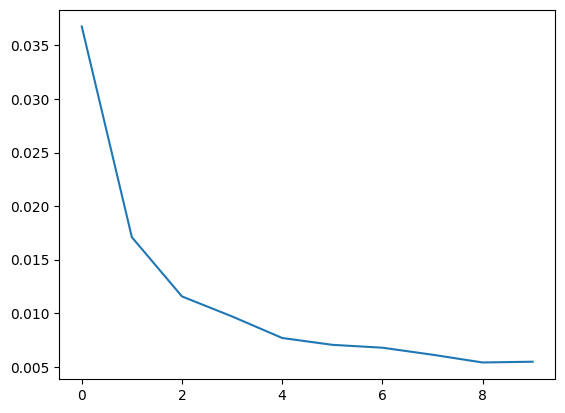

In [53]:
plt.plot(loss_history)

## 7. Generate Images with Trained Model

In [54]:
%%time
random_selected_data = hf_dataset.shuffle().select(range(4*4))[:]
gen_img = generate(model, texts=random_selected_data['text'], cond_images=random_selected_data['conditioning_image'])

CPU times: user 50.3 s, sys: 431 ms, total: 50.7 s
Wall time: 51.6 s


In [59]:
gt_images = torch.stack([conditioning_image_transforms(img) for img in random_selected_data['image']], dim=0)

In [56]:
gen_img = 0.5 * gen_img + 0.5

['burly wood circle with aquamarine background', 'green circle with dark turquoise background', 'medium aquamarine circle with crimson background', 'peach puff circle with dark salmon background', 'antique white circle with dark golden rod background', 'dodger blue circle with peach puff background', 'medium aquamarine circle with sky blue background', 'indigo circle with beige background', 'light steel blue circle with orchid background', 'light golden rod yellow circle with hot pink background', 'gold circle with dark red background', 'dark green circle with white smoke background', 'dark olive green circle with white background', 'olive circle with beige background', 'white smoke circle with cadet blue background', 'teal circle with dark slate blue background']


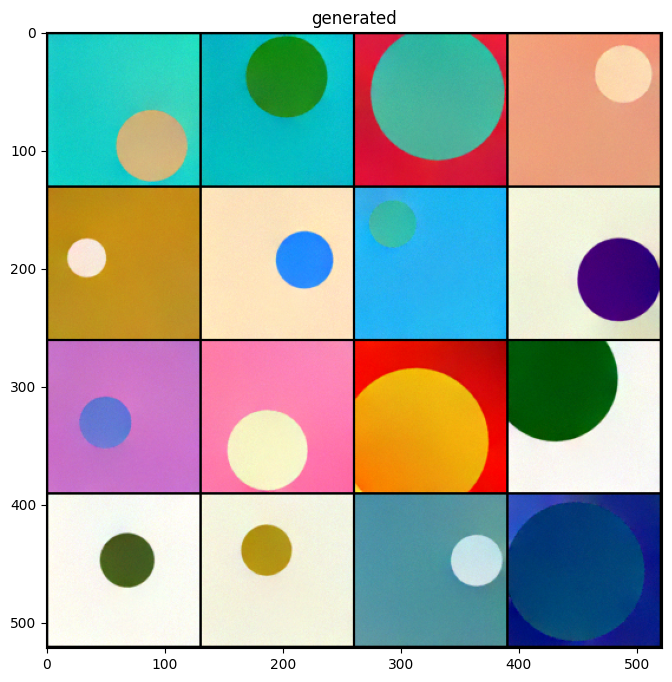

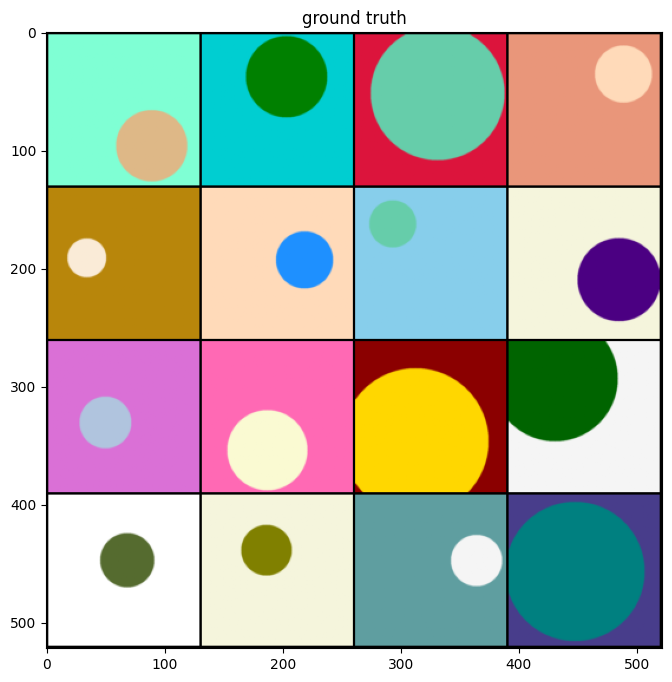

In [60]:
print(random_selected_data['text'])

grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))
plt.title('generated')
plt.show()

grid_gt_image = torchvision.utils.make_grid(gt_images.cpu(), nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_gt_image.permute(1, 2, 0))
plt.title('ground truth')
plt.show()

In [61]:
%%time
gen_img = generate(model, texts=16*[random_selected_data['text'][0]], cond_images=random_selected_data['conditioning_image'])

CPU times: user 43.1 s, sys: 108 ms, total: 43.2 s
Wall time: 48.1 s


In [62]:
gt_images = torch.stack([conditioning_image_transforms(img) for img in random_selected_data['conditioning_image']], dim=0)

In [63]:
gen_img = 0.5 * gen_img + 0.5

burly wood circle with aquamarine background


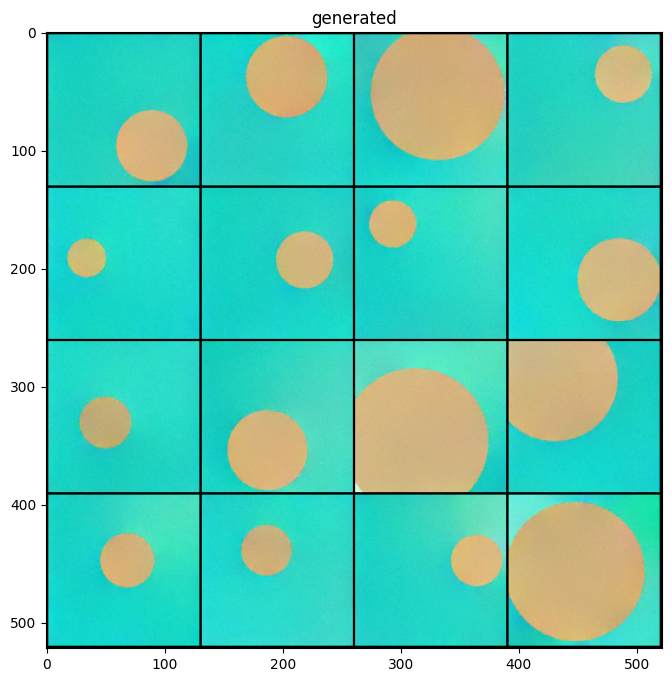

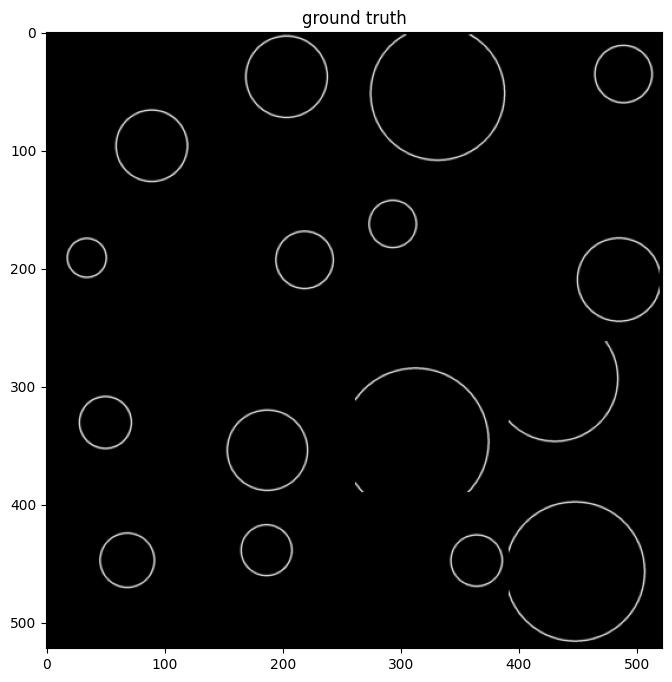

In [64]:
print(random_selected_data['text'][0])

grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))
plt.title('generated')
plt.show()

grid_gt_image = torchvision.utils.make_grid(gt_images.cpu(), nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_gt_image.permute(1, 2, 0))
plt.title('ground truth')
plt.show()

In [65]:
%%time
gen_img = generate(model, texts=random_selected_data['text'], cond_images=16*[random_selected_data['conditioning_image'][0]])

CPU times: user 43.9 s, sys: 69.8 ms, total: 43.9 s
Wall time: 48.2 s


In [66]:
gen_img = 0.5 * gen_img + 0.5

['burly wood circle with aquamarine background', 'green circle with dark turquoise background', 'medium aquamarine circle with crimson background', 'peach puff circle with dark salmon background', 'antique white circle with dark golden rod background', 'dodger blue circle with peach puff background', 'medium aquamarine circle with sky blue background', 'indigo circle with beige background', 'light steel blue circle with orchid background', 'light golden rod yellow circle with hot pink background', 'gold circle with dark red background', 'dark green circle with white smoke background', 'dark olive green circle with white background', 'olive circle with beige background', 'white smoke circle with cadet blue background', 'teal circle with dark slate blue background']


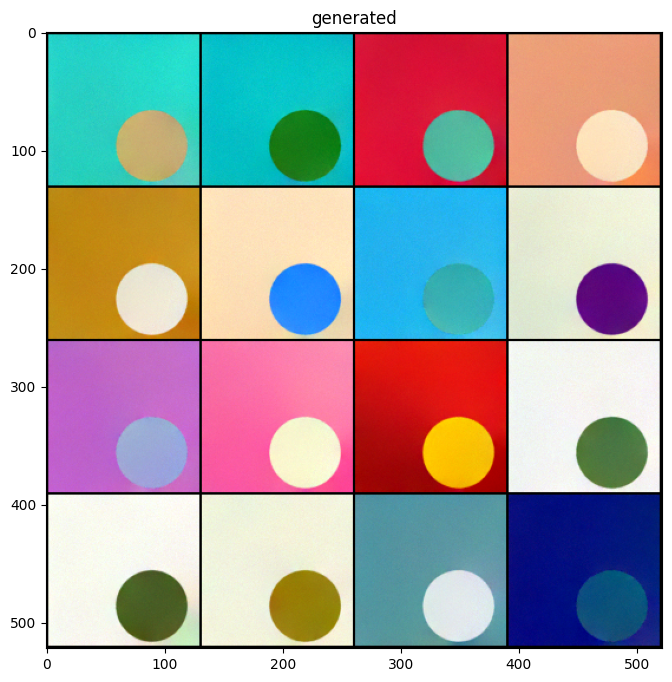

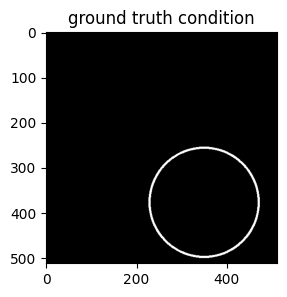

In [68]:
print(random_selected_data['text'])

grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))
plt.title('generated')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(np.asarray(random_selected_data['conditioning_image'][0]))
plt.title('ground truth condition')
plt.show()

In [69]:
%%time
random_selected_data = hf_dataset.shuffle().select(range(4*4))[:]
gen_img = generate(model, texts=16*[random_selected_data['text'][0]], cond_images=16*[random_selected_data['conditioning_image'][0]])

CPU times: user 40.7 s, sys: 434 ms, total: 41.2 s
Wall time: 51.2 s


In [70]:
gt_images = torch.stack([conditioning_image_transforms(img) for img in random_selected_data['image']], dim=0)

In [71]:
gen_img = 0.5 * gen_img + 0.5

snow circle with medium blue background


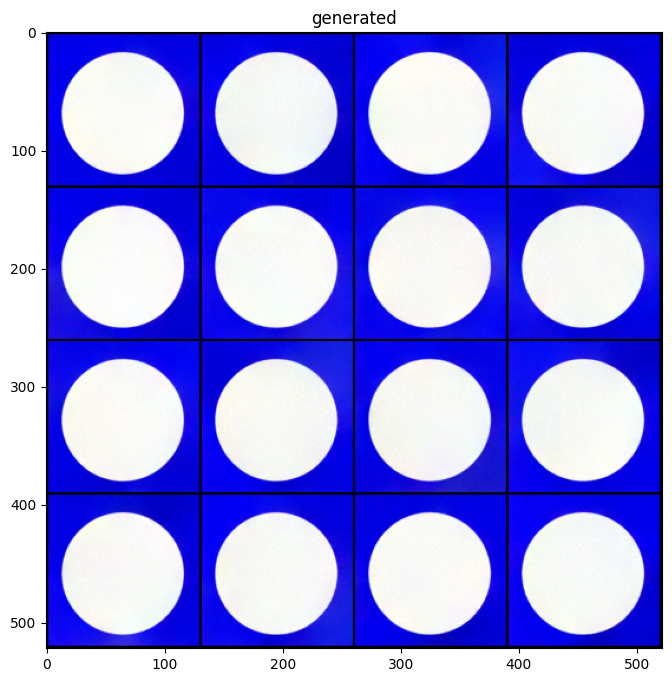

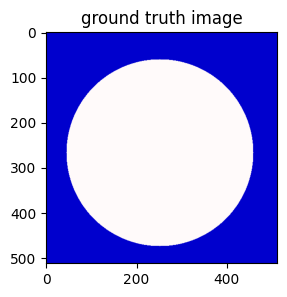

In [72]:
print(random_selected_data['text'][0])

grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))
plt.title('generated')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(np.asarray(random_selected_data['image'][0]))
plt.title('ground truth image')
plt.show()